In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import os
os.chdir('9444')

In [3]:
!pwd

/d/LSL/9444


# VQAv2 dataset preview

In [16]:
import sys
sys.path.append('D:\LSL\9444\VQA')
from PythonHelperTools.vqaTools import vqa # VQA cloned from VQAv2's github with someone's modification to work in python3

In [4]:
!pwd

/d/LSL/9444


In [25]:
import os
import json
from pprint import pprint

with open(os.path.join('dataset', 'merged_data.json'), 'r') as f:
    data1 =json.load(f)

with open(os.path.join('VQA', 'Annotations', 'v2_mscoco_val2014_annotations.json'), 'r') as f:
    data2 =json.load(f)

with open(os.path.join('VQA', 'Questions', 'v2_OpenEnded_mscoco_val2014_questions.json'), 'r') as f:
    data3 =json.load(f)

In [22]:
# Print the top-level keys
print("Top-level keys:", data2.keys() if isinstance(data2, dict) else "Data is a list")

pprint(data2['annotations'][0])
pprint(data2['annotations'][0])

Top-level keys: dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])
{'answer_type': 'other',
 'answers': [{'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 1},
             {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 2},
             {'answer': 'at table', 'answer_confidence': 'yes', 'answer_id': 3},
             {'answer': 'skateboard',
              'answer_confidence': 'yes',
              'answer_id': 4},
             {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 5},
             {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 6},
             {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 7},
             {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 8},
             {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 9},
             {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 262148,
 'multiple_choice_answer': 'down',
 'question_id': 2

In [24]:
pprint(data2['annotations'][2])

{'answer_type': 'other',
 'answers': [{'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 1},
             {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 2},
             {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 3},
             {'answer': 'picnic table',
              'answer_confidence': 'yes',
              'answer_id': 4},
             {'answer': 'picnic table',
              'answer_confidence': 'yes',
              'answer_id': 5},
             {'answer': 'picnic table',
              'answer_confidence': 'yes',
              'answer_id': 6},
             {'answer': 'picnic table',
              'answer_confidence': 'yes',
              'answer_id': 7},
             {'answer': 'picnic table',
              'answer_confidence': 'yes',
              'answer_id': 8},
             {'answer': 'skateboard',
              'answer_confidence': 'yes',
              'answer_id': 9},
             {'answer': 'picnic table',
              'answer_con

In [12]:
data1[0]

{'answerable': 1,
 'image': 262148,
 'question': 'Where is he looking?',
 'answer_type': 'other',
 'answers': [{'answer': 'down', 'answer_confidence': 'yes'},
  {'answer': 'down', 'answer_confidence': 'yes'},
  {'answer': 'at table', 'answer_confidence': 'yes'},
  {'answer': 'skateboard', 'answer_confidence': 'yes'},
  {'answer': 'down', 'answer_confidence': 'yes'},
  {'answer': 'table', 'answer_confidence': 'yes'},
  {'answer': 'down', 'answer_confidence': 'yes'},
  {'answer': 'down', 'answer_confidence': 'yes'},
  {'answer': 'down', 'answer_confidence': 'yes'},
  {'answer': 'down', 'answer_confidence': 'yes'}]}

In [32]:
print("Top-level keys:", data3.keys() if isinstance(data3, dict) else "Data is a list")

# for key in data3.keys():
#     pprint(data3[key])
pprint(data3['questions'][0])

Top-level keys: dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
{'image_id': 262148,
 'question': 'Where is he looking?',
 'question_id': 262148000}


In [5]:
import json
def merge_question_answer(question_file, answer_file):
    with open(question_file, 'r') as f:
        question_data = json.load(f)

    with open(answer_file, 'r') as f:
        answer_data = json.load(f)

    merged_data = []

    answer_dict = {annotation['question_id']: annotation for annotation in answer_data['annotations']}

    for question in question_data['questions']:
        qid = question['question_id']

        if qid in answer_dict:
            answer_entry = answer_dict[qid]['multiple_choice_answer']

            merged_entry = {
                "image_id": question['image_id'],
                "question": question['question'],
                "answer": answer_entry
            }
            merged_data.append(merged_entry)

    return merged_data

In [6]:
question_file = os.path.join('VQA', 'Questions', 'v2_OpenEnded_mscoco_val2014_questions.json')
answer_file = os.path.join('VQA', 'Annotations', 'v2_mscoco_val2014_annotations.json')

merged_data = merge_question_answer(question_file, answer_file)
with open(os.path.join('dataset', 'merged_data_2.json'), 'w') as f:
    json.dump(merged_data, f, indent=4)

print(merged_data[:2])

[{'image_id': 262148, 'question': 'Where is he looking?', 'answer': 'down'}, {'image_id': 262148, 'question': 'What are the people in the background doing?', 'answer': 'watching'}]


# Data Processing

## Define custom class VQADataset

In [1]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""
    def __init__(self, dataset_load, processor_load):
        self.dataset = dataset_load
        self.processor = processor_load

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        question = self.dataset[idx]['question']
        answer = self.dataset[idx]['answer']
        image_id = self.dataset[idx]['image_id']
        image_files_dir = os.path.join('dataset', 'val2014')
        image_name = 'COCO_val2014_' + '0' * (12 - len(str(image_id))) + str(image_id) + '.jpg'
        image_path = os.path.join(image_files_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        text = question
        
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
        labels = self.processor.tokenizer.encode(
            answer,
            max_length= 8,
            truncation=True,
            padding="max_length",
            return_tensors='pt',
            return_attention_mask=True
        )
        encoding["labels"] = labels
        # remove batch dimension
        for k,v in encoding.items():  encoding[k] = v.squeeze()
        return encoding

## Load model checkpoint

In [3]:
from transformers import BlipProcessor, BlipForQuestionAnswering

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

torch.manual_seed(42)

cuda


In [4]:
os.chdir('9444')

In [4]:
import os
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset

dataset_json_path = os.path.join('dataset', 'merged_data_2.json')

# training_data = load_dataset("json", data_files=dataset_json_path, split="train[:70%]")
# valid_data = load_dataset("json", data_files=dataset_json_path, split="train[70%:]")

full_dataset = load_dataset("json", data_files=dataset_json_path, split="train[:1%]")
df = full_dataset.to_pandas()
train_df, val_df = train_test_split(df, train_size=0.7, random_state=42)
# Convert back to Hugging Face Datasets
training_data = Dataset.from_pandas(train_df)
valid_data = Dataset.from_pandas(val_df)

training_set = VQADataset(dataset_load=training_data, processor_load=processor)
valid_set = VQADataset(dataset_load=valid_data, processor_load=processor)

In [5]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
BATCH_SIZE = 16

def custom_collate(batch):
    # Separate each element in the batch
    input_ids = [item["input_ids"] for item in batch]
    pixel_values = [item["pixel_values"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Pad sequences to the maximum length in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)  # Adjust padding_value as needed
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for ignored labels in NLP

    # Stack other fixed-size tensors
    pixel_values_stacked = torch.stack(pixel_values)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    # Return the batch as a dictionary
    return {
        "input_ids": input_ids_padded,
        "pixel_values": pixel_values_stacked,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded,
    }

# Use this collate function in your DataLoader
train_dataloader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)


# LoRA config

In [6]:
for name, module in model.named_modules():
    print(name)


vision_model
vision_model.embeddings
vision_model.embeddings.patch_embedding
vision_model.encoder
vision_model.encoder.layers
vision_model.encoder.layers.0
vision_model.encoder.layers.0.self_attn
vision_model.encoder.layers.0.self_attn.dropout
vision_model.encoder.layers.0.self_attn.qkv
vision_model.encoder.layers.0.self_attn.projection
vision_model.encoder.layers.0.layer_norm1
vision_model.encoder.layers.0.mlp
vision_model.encoder.layers.0.mlp.activation_fn
vision_model.encoder.layers.0.mlp.fc1
vision_model.encoder.layers.0.mlp.fc2
vision_model.encoder.layers.0.layer_norm2
vision_model.encoder.layers.1
vision_model.encoder.layers.1.self_attn
vision_model.encoder.layers.1.self_attn.dropout
vision_model.encoder.layers.1.self_attn.qkv
vision_model.encoder.layers.1.self_attn.projection
vision_model.encoder.layers.1.layer_norm1
vision_model.encoder.layers.1.mlp
vision_model.encoder.layers.1.mlp.activation_fn
vision_model.encoder.layers.1.mlp.fc1
vision_model.encoder.layers.1.mlp.fc2
visio

In [7]:
text_encoder_target_modules = [
    f"text_encoder.encoder.layer.{i}.attention.self.query" for i in range(11, 12)
] + [
    # f"text_encoder.encoder.layer.{i}.attention.self.key" for i in range(11, 13)
] + [
    # f"text_encoder.encoder.layer.{i}.attention.self.value" for i in range(11, 13)
]


In [8]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8, # rank of the low-rank matrices that LoRA uses to modify certain parts of the model
    lora_alpha=32, # scale LoRA weights, effectively controlling how strongly the LoRA layers impact the model’s predictions
    lora_dropout=0.05, # 
    bias="none", # whether or not to add biases to the LoRA-modified layers
    target_modules=text_encoder_target_modules       # specifies the exact layers in the model where LoRA should be applied, typically in attention mechanisms
                                        # ["q_proj", "k_proj"] are standard as they affect the query and key projections in attention layers
)

lora_model = get_peft_model(model, config)
lora_model.print_trainable_parameters()

trainable params: 12,288 || all params: 384,684,860 || trainable%: 0.0032


## switch the whole model to float16

# Train

## Function to save and load training check point

In [16]:
from transformers import BlipProcessor, BlipForQuestionAnswering

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

test_model = BlipForQuestionAnswering.from_pretrained('BLIP_checkpoints\\train1\\checkpoint1').to(device)
test_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')

cuda


Some weights of the model checkpoint at BLIP_checkpoints\train1\checkpoint1 were not used when initializing BlipForQuestionAnswering: ['text_encoder.encoder.layer.11.attention.self.query.base_layer.bias', 'text_encoder.encoder.layer.11.attention.self.query.base_layer.weight', 'text_encoder.encoder.layer.11.attention.self.query.lora_A.default.weight', 'text_encoder.encoder.layer.11.attention.self.query.lora_B.default.weight']
- This IS expected if you are initializing BlipForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BlipForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BlipForQuestionAnswering were not initialized from the model checkpoint 

In [12]:
for name, param in test_model.named_parameters():
    if param.dtype == torch.float32:
        param.data = param.data.half()  # Convert to float16
        print(f"Converted {name} to float16.")
for name, param in test_model.named_parameters():
    print(f"{name}: {param.dtype}")

Converted vision_model.embeddings.class_embedding to float16.
Converted vision_model.embeddings.position_embedding to float16.
Converted vision_model.embeddings.patch_embedding.weight to float16.
Converted vision_model.embeddings.patch_embedding.bias to float16.
Converted vision_model.encoder.layers.0.self_attn.qkv.weight to float16.
Converted vision_model.encoder.layers.0.self_attn.qkv.bias to float16.
Converted vision_model.encoder.layers.0.self_attn.projection.weight to float16.
Converted vision_model.encoder.layers.0.self_attn.projection.bias to float16.
Converted vision_model.encoder.layers.0.layer_norm1.weight to float16.
Converted vision_model.encoder.layers.0.layer_norm1.bias to float16.
Converted vision_model.encoder.layers.0.mlp.fc1.weight to float16.
Converted vision_model.encoder.layers.0.mlp.fc1.bias to float16.
Converted vision_model.encoder.layers.0.mlp.fc2.weight to float16.
Converted vision_model.encoder.layers.0.mlp.fc2.bias to float16.
Converted vision_model.encoder.

In [17]:
import os
os.chdir('9444')

FileNotFoundError: [WinError 2] 系统找不到指定的文件。: '9444'

cuda:0


kitchen


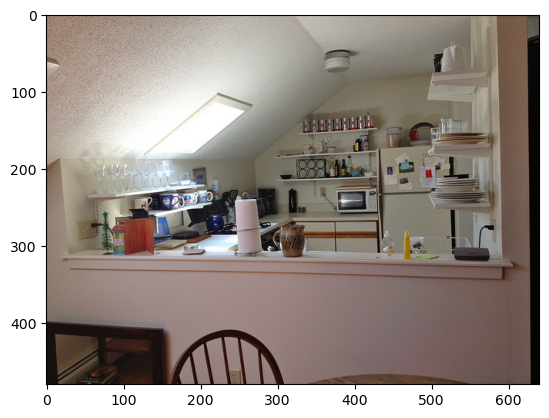

In [17]:
import matplotlib.pyplot as plt

# Read and display the image using matplotlib
image_path = 'dataset/val2014/COCO_val2014_000000000164.jpg'
image = plt.imread(image_path)
plt.imshow(image)
question = 'where is this place?'
inputs = test_processor(image, question, return_tensors="pt").to('cuda:0', torch.float16)
# print(inputs.device)  # Should print "cuda:0" if it's on GPU
print(test_model.device)
out = test_model.generate(**inputs)

output_text = test_processor.decode(out[0], skip_special_tokens=True)
print(output_text)

In [13]:
from tqdm import tqdm
import pickle

def train(model, train_dataloader, valid_dataloader, num_epochs, optimizer, patience, scheduler, checkpoint_path="checkpoint.pth"):
    # Load checkpoint if exists
    start_epoch, min_eval_loss, early_stopping_hook = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
    scaler = torch.amp.GradScaler("cuda")  # Updated as per latest method
    tracking_information = []

    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0
        model.train()
        for idx, batch in zip(tqdm(range(len(train_dataloader)), desc='Training batch: ...'), train_dataloader):
            input_ids = batch.pop('input_ids').to(device)
            pixel_values = batch.pop('pixel_values').to(device)
            attention_masked = batch.pop('attention_mask').to(device)
            labels = batch.pop('labels').to(device)
            
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=labels)
                
            loss = outputs.loss
            epoch_loss += loss.item()
            optimizer.zero_grad()
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        model.eval()
        eval_loss = 0
        for idx, batch in zip(tqdm(range(len(valid_dataloader)), desc='Validating batch: ...'), valid_dataloader):
            input_ids = batch.pop('input_ids').to(device)
            pixel_values = batch.pop('pixel_values').to(device)
            attention_masked = batch.pop('attention_mask').to(device)
            labels = batch.pop('labels').to(device)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_masked,
                            labels=labels)
            
            loss = outputs.loss
            eval_loss += loss.item()

        tracking_information.append((epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
        print("Epoch: {} - Training loss: {} - Eval Loss: {} - LR: {}".format(epoch+1, epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
        scheduler.step()

        # Save model if it has the lowest evaluation loss
        if eval_loss < min_eval_loss:
            saved_path = os.path.join('BLIP_tuned_model')
            model.save_pretrained(saved_path, from_pt=True) 
            print(f'Saved model to {os.path.abspath(saved_path)}')
            min_eval_loss = eval_loss
            early_stopping_hook = 0
        else:
            early_stopping_hook += 1
            if early_stopping_hook > patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    pickle.dump(tracking_information, open(os.path.join('BLIP_tuned_model', 'tracking_info.pkl'), "wb"))
    print("The finetuning process has done!")

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

NUM_EPOCHS = 50
PATIENCE = 10

checkpoint_path = os.path.join('BLIP_tuned_model')


import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.empty_cache()
train(model=lora_model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    num_epochs=NUM_EPOCHS,
    optimizer=optimizer,
    patience=PATIENCE,
    scheduler=scheduler,
    checkpoint_path=checkpoint_path
    )

Validating batch: ...: 100%|███████████████████████████████████████████████████████| 4020/4020 [53:10<00:00,  1.26it/s]


Epoch: 1 - Training loss: 9.724935427787946 - Eval Loss: 9.24495366319495 - LR: 4e-05
Saved model to D:\LSL\9444\BLIP_tuned_model


RuntimeError: File BLIP_tuned_model cannot be opened.

# Save at every epoch version

In [9]:
import os
from transformers import BlipForQuestionAnswering, BlipProcessor
from tqdm import tqdm
import pickle
import torch

def get_latest_session_and_checkpoint(root_folder):
    # Get list of all training sessions
    sessions = sorted([d for d in os.listdir(root_folder) if d.startswith('train')])
    if not sessions:
        return None, None
    
    # Latest session directory
    latest_session = sessions[-1]
    session_path = os.path.join(root_folder, latest_session)
    
    # Get the latest checkpoint in the latest session
    checkpoints = sorted([ckpt for ckpt in os.listdir(session_path) if ckpt.startswith('checkpoint')])
    if not checkpoints:
        return session_path, None
    
    latest_checkpoint = checkpoints[-1]
    return session_path, os.path.join(session_path, latest_checkpoint)

In [16]:
import os
from transformers import BlipForQuestionAnswering, BlipProcessor
from tqdm import tqdm
import pickle
import torch

def train(model, processor, train_dataloader, valid_dataloader, num_epochs, root_folder='BLIP_checkpoints', resume_training=False, patience=3):
    
    
    # Locate the session path
    latest_session_num = max([int(d[5:]) for d in os.listdir(root_folder) if d.startswith('train')], default=0)
    session_num = latest_session_num + 1 if not resume_training else latest_session_num
    session_path = os.path.join(root_folder, f'train{session_num}')
    os.makedirs(session_path, exist_ok=True)

    # Path to save the best model
    best_model_path = os.path.join(session_path, 'best_model')
    os.makedirs(best_model_path, exist_ok=True)

    # Initialize training state
    start_epoch = 0
    min_eval_loss = float('inf')
    early_stopping_hook = 0

    # Load the latest checkpoint if resuming training
    if resume_training:
        latest_session_path, latest_checkpoint_path = get_latest_session_and_checkpoint(root_folder)
        if latest_checkpoint_path:
            print(f"Resuming from checkpoint at {latest_checkpoint_path}")
            base_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
            processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
            model = PeftModel.from_pretrained(base_model, latest_checkpoint_path)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            for param in model.parameters():
                param.requires_grad = False  # Set all params to non-trainable first
            for name, param in model.named_parameters():
                if "lora" in name:  # Customize based on LoRA layers naming convention
                    param.requires_grad = True
            model.print_trainable_parameters()
            start_epoch = int(latest_checkpoint_path.split('checkpoint')[-1])

    # Initialize the gradient scaler for mixed precision
    scaler = torch.amp.GradScaler("cuda")
    tracking_information = []
    optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0
        model.train()

        for batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
            input_ids = batch.pop('input_ids').to(model.device)
            pixel_values = batch.pop('pixel_values').to(model.device)
            attention_mask = batch.pop('attention_mask').to(model.device)
            labels = batch.pop('labels').to(model.device)

            with torch.amp.autocast("cuda"):
                outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            epoch_loss += loss.item()
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        tracking_information.append({'epoch': epoch + 1, 'train_loss': avg_epoch_loss})

        # Validation step
        model.eval()
        eval_loss = 0

        with torch.no_grad():
            for batch in tqdm(valid_dataloader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):
                input_ids = batch.pop('input_ids').to(model.device)
                pixel_values = batch.pop('pixel_values').to(model.device)
                attention_mask = batch.pop('attention_mask').to(model.device)
                labels = batch.pop('labels').to(model.device)

                with torch.amp.autocast("cuda"):
                    outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(valid_dataloader)
        tracking_information[-1]['eval_loss'] = avg_eval_loss
        print(f"Epoch {epoch+1}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_eval_loss}")
        scheduler.step()

        # Save checkpoint at the end of each epoch
        checkpoint_path = os.path.join(session_path, f'checkpoint{epoch + 1}')
        model.save_pretrained(checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

        # Save best model
        if avg_eval_loss < min_eval_loss:
            model.save_pretrained(best_model_path)
            min_eval_loss = avg_eval_loss
            early_stopping_hook = 0
            print(f"New best model saved at {best_model_path}")
        else:
            early_stopping_hook += 1
            if early_stopping_hook > patience:
                print("Early stopping triggered.")
                break

    # Save tracking information
    tracking_info_path = os.path.join(session_path, 'tracking_info.pkl')
    with open(tracking_info_path, "wb") as f:
        pickle.dump(tracking_information, f)
    print(f"Training complete. Tracking information saved to {tracking_info_path}")


In [18]:
import os
import torch
from peft import PeftModel

# Training parameters
NUM_EPOCHS = 50
PATIENCE = 10
ROOT_FOLDER = 'BLIP_checkpoints'

# Environment setup
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.empty_cache()

# Start training with the aligned function
train(
    model=lora_model,
    processor=processor,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    num_epochs=NUM_EPOCHS,
    root_folder=ROOT_FOLDER,
    resume_training=True,  # Set to True if you want to resume from the latest session
    patience=PATIENCE
)


Resuming from checkpoint at BLIP_checkpoints\train7\checkpoint2


KeyboardInterrupt: 

Answer: 0


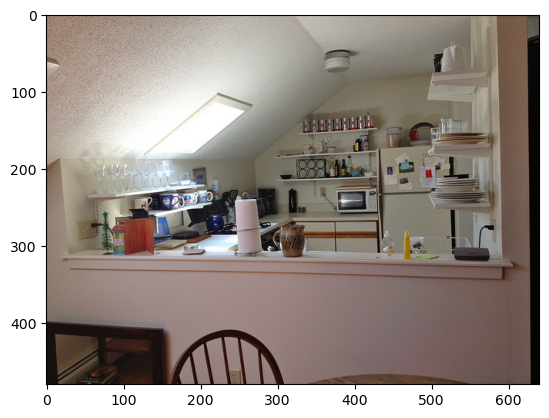

In [ ]:
from transformers import BlipForQuestionAnswering, BlipProcessor
from peft import PeftModel  # Assuming you are using PEFT library for LoRA
import torch
import matplotlib.pyplot as plt

# Step 1: Load the base model
base_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')

# Step 2: Load the LoRA adapters
adapter_model_path = "BLIP_checkpoints\\train4\\checkpoint1"  # Replace with the path where the LoRA adapter is saved
lora_model = PeftModel.from_pretrained(base_model, adapter_model_path)

# Step 3: Move to device if using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lora_model.to(device)

# Step 4: Use the model
# Example input
image_path = 'dataset/val2014/COCO_val2014_000000000164.jpg'
image = plt.imread(image_path)
plt.imshow(image)
question = "how many aluminum cans in the image?"
inputs = processor(images=image, text=question, return_tensors="pt").to(device)

# Generate an answer
with torch.no_grad():
    output = lora_model.generate(**inputs, max_new_tokens=20)
answer = processor.decode(output[0], skip_special_tokens=True)
print("Answer:", answer)
